#### regarding bigWig -> still have to double check what is the "sum" metadata that it reports -> sum of individual counts, or "integral" over the counts along the genome ...

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
feat_names = OrderedDict()
feat_names["ctcf"] = "intersect-all-NT-CTCF-NO-G4-centered-RAD21"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end","strand"],
        usecols=(0,1,2,3),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


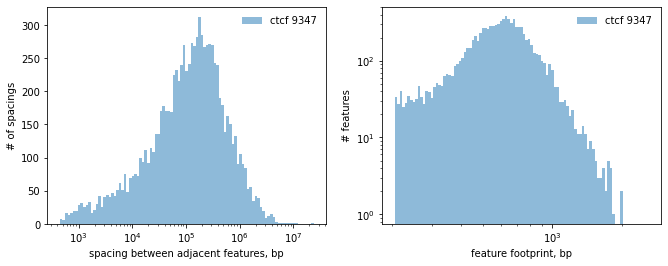

In [6]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [7]:
#let's describe our samples that we want to have in Figure 1 ...
supfig3b_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","rad21_rad21","rad21_norad21",
                    "ins_CTCF","ins_noCTCF",
                    "ins_rad21","ins_norad21",
                    "ins_polII","ins_nopolII",
    #                 "ev1_CTCF","ev1_noCTCF","ev1_polII","ev1_nopolII","ddx_CTCF","ddx_noCTCF","taf5l_CTCF","taf5l_noCTCF",
                    "Rloop_K562","polII",'h3k4_r1',"mrna_ctcf"]

titles = supfig3b_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in supfig3b_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

In [8]:
#let's describe our samples that we want to have in Figure 1 ...
# "ddx_CTCF","ddx_noCTCF"
plot_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ddx_CTCF","ddx_noCTCF",'taf5l_CTCF','taf5l_noCTCF','h3k4_r1',"mrna_ctcf"]

titles = plot_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in plot_samples + ["rad21_CTCF_r2","rad21_noCTCF_r2","ddx_CTCF_r2","ddx_noCTCF_r2",'taf5l_CTCF_r2','taf5l_noCTCF_r2']:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [9]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf:(9347) ...


stacking up ctcf ...
CPU times: user 1.63 s, sys: 157 ms, total: 1.79 s
Wall time: 1.78 s
stacking up noctcf ...
CPU times: user 1.47 s, sys: 119 ms, total: 1.59 s
Wall time: 1.62 s
stacking up rad21_CTCF ...
CPU times: user 1.74 s, sys: 160 ms, total: 1.9 s
Wall time: 1.89 s
stacking up rad21_noCTCF ...
CPU times: user 1.35 s, sys: 140 ms, total: 1.49 s
Wall time: 1.48 s
stacking up ins_CTCF ...
CPU times: user 1.13 s, sys: 92 ms, total: 1.22 s
Wall time: 1.22 s
stacking up ins_noCTCF ...
CPU times: user 1.13 s, sys: 68.6 ms, total: 1.2 s
Wall time: 1.21 s
stacking up ddx_CTCF ...
CPU times: user 1.49 s, sys: 152 ms, total: 1.65 s
Wall time: 1.72 s
stacking up ddx_noCTCF ...
CPU times: user 1.36 s, sys: 107 ms, total: 1.47 s
Wall time: 1.52 s
stacking up taf5l_CTCF ...
CPU times: user 1.55 s, sys: 106 ms, total: 1.65 s
Wall time: 1.72 s
stacking up taf5l_noCTCF ...
CPU times: user 1.32 s, sys: 69.1 ms, total: 1.39 s
Wall time: 1.45 s
stackin

In [10]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for ctcf ...


In [11]:
from copy import copy
flip_stackup_dict = copy(stackup_dict)

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [12]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in flip_stackup_dict:
    the_stackup = flip_stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [13]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.03)
    cmps[s] = cmapYlGnBu_r

In [14]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ddx_CTCF'].shape
    center_bin = int(width/2)

    the_stackups['ddx_mean'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _sorting_key = "ddx_mean"

    _, _jjj = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(the_stackups[_sorting_key]) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 9347 elements of ddx_mean into 1 groups ...


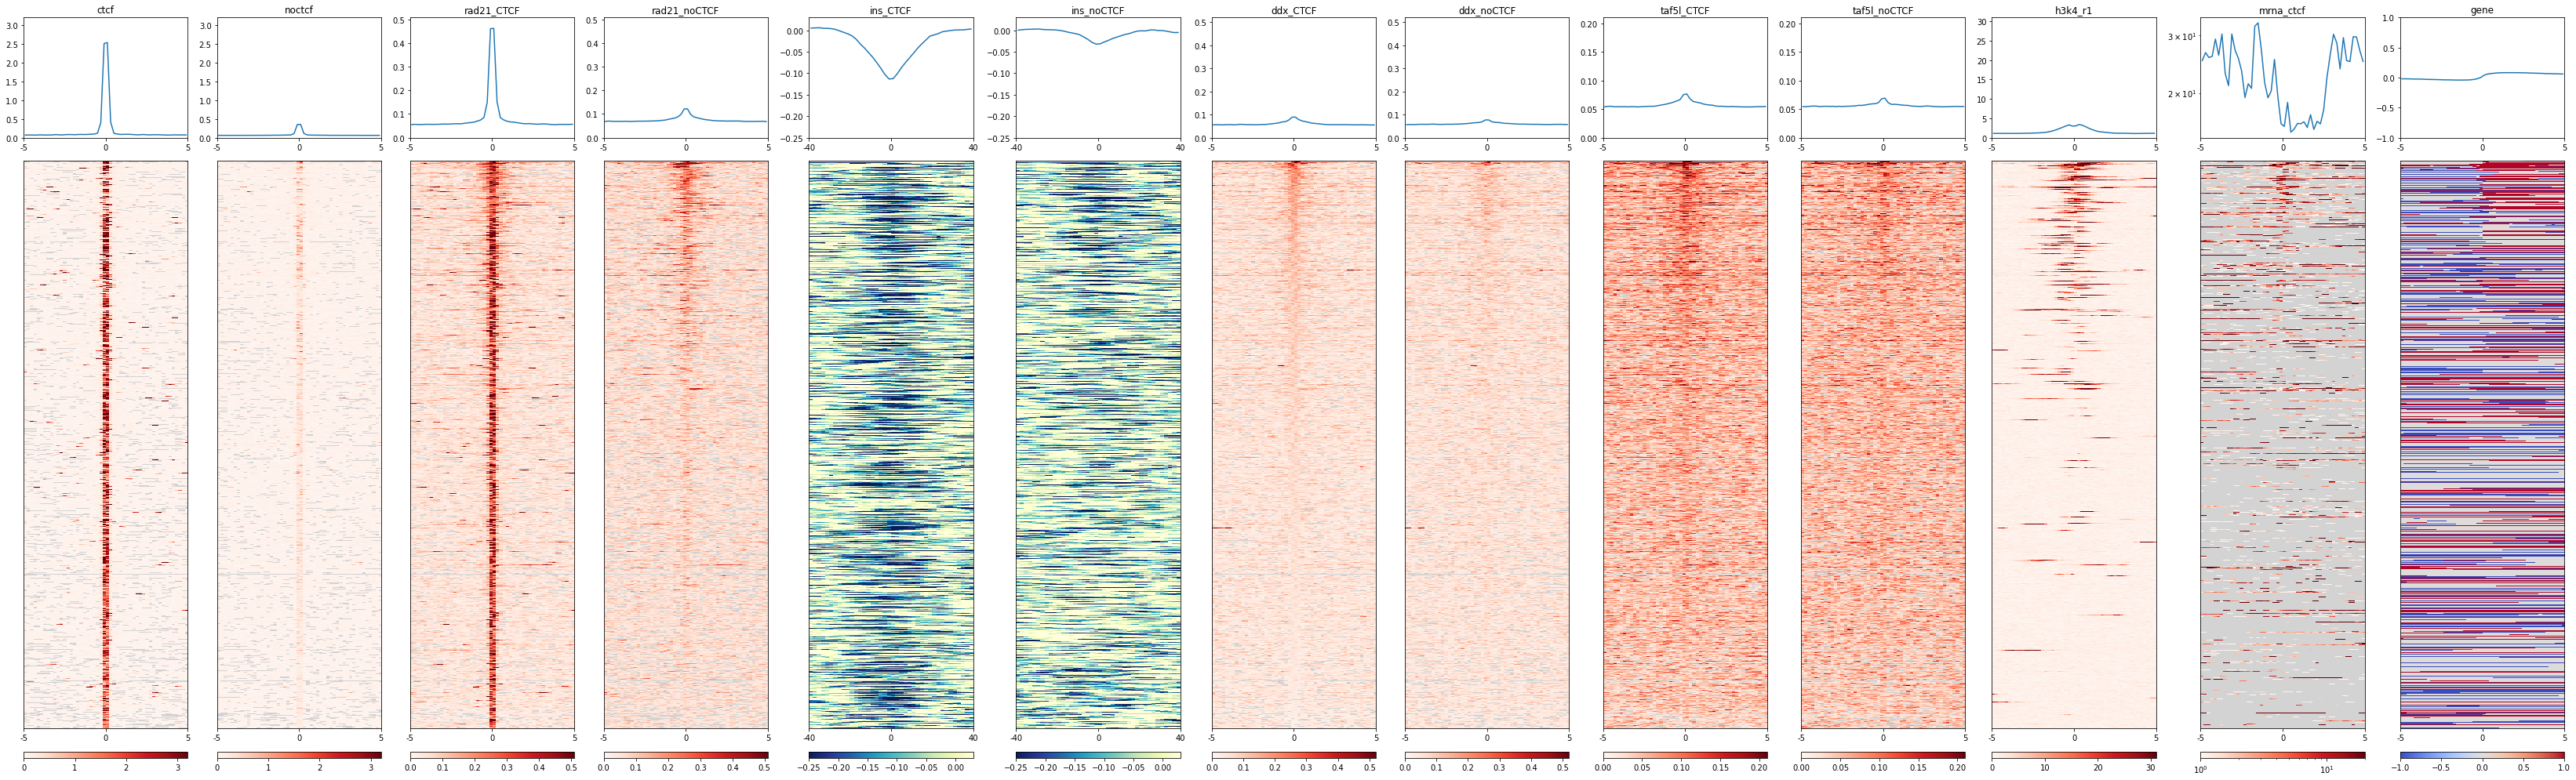

In [15]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in plot_samples ]

_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group
plt.savefig("SuppFig5G-ctcf.pdf")

In [16]:
quantification_keys = [
                'rad21_iaa_mean_r1',
                'rad21_mean_r1',
                'rad21_iaa_mean_r2',
                'rad21_mean_r2',
                'ddx_iaa_mean_r1',
                'taf_iaa_mean_r1',
                'ddx_mean_r1',
                'taf_mean_r1',
                'ddx_iaa_mean_r2',
                'taf_iaa_mean_r2',
                'ddx_mean_r2',
                'taf_mean_r2',
]

quant_dfs_dict = {}


for feature_key in flip_stackup_dict:
    jjj = reordered_jdxs[feature_key]
    the_stackups = {_k:flip_stackup_dict[feature_key][_k][jjj[:]] for _k in  flip_stackup_dict[feature_key].keys()}
    # for  a given set of stackups for a given list of features ...
    length,width = the_stackups['rad21_CTCF'].shape
    center_bin = int(width/2)

    # replicate 1 RAD21 in CTCF-degron and degron+AUX
    the_stackups['rad21_iaa_mean_r1'] = np.nanmean(the_stackups['rad21_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rad21_mean_r1'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-1:center_bin+1],axis=1)
    
    the_stackups['rad21_iaa_mean_r2'] = np.nanmean(the_stackups['rad21_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rad21_mean_r2'] = np.nanmean(the_stackups['rad21_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)

    the_stackups['taf_iaa_mean_r1'] = np.nanmean(the_stackups['taf5l_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_mean_r1'] = np.nanmean(the_stackups['taf5l_CTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_iaa_mean_r2'] = np.nanmean(the_stackups['taf5l_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['taf_mean_r2'] = np.nanmean(the_stackups['taf5l_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    
    # replicate 1, DDX and TAF in CTCF-degron and CTCF-degron+AUX
    the_stackups['ddx_iaa_mean_r1'] = np.nanmean(the_stackups['ddx_noCTCF'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['ddx_mean_r1'] = np.nanmean(the_stackups['ddx_CTCF'][:,center_bin-1:center_bin+1],axis=1)
    # replicate 2, DDX and TAF in CTCF-degron and CTCF-degron+AUX
    the_stackups['ddx_iaa_mean_r2'] = np.nanmean(the_stackups['ddx_noCTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['ddx_mean_r2'] = np.nanmean(the_stackups['ddx_CTCF_r2'][:,center_bin-1:center_bin+1],axis=1)
    
    quant_dfs_dict[feature_key] = pd.DataFrame({ k:the_stackups[k]  for k in quantification_keys })

    

In [17]:
# let's calcuate fold changes for the interesting cases ...

dat = {}
dat["ctcf-rad21-1"] = (quant_dfs_dict["ctcf"]['rad21_iaa_mean_r1'] / quant_dfs_dict["ctcf"]['rad21_mean_r1'])
dat["ctcf-rad21-2"] = (quant_dfs_dict["ctcf"]['rad21_iaa_mean_r2'] / quant_dfs_dict["ctcf"]['rad21_mean_r2'])
dat["ctcf-ddx-1"] = (quant_dfs_dict["ctcf"]['ddx_iaa_mean_r1'] / quant_dfs_dict["ctcf"]['ddx_mean_r1'])
dat["ctcf-ddx-2"] = (quant_dfs_dict["ctcf"]['ddx_iaa_mean_r2'] / quant_dfs_dict["ctcf"]['ddx_mean_r2'])
dat["ctcf-taf-1"] = (quant_dfs_dict["ctcf"]['taf_iaa_mean_r1'] / quant_dfs_dict["ctcf"]['taf_mean_r1'])
dat["ctcf-taf-2"] = (quant_dfs_dict["ctcf"]['taf_iaa_mean_r2'] / quant_dfs_dict["ctcf"]['taf_mean_r2'])

In [18]:
hist_samples = ["ctcf-rad21",
                "ctcf-ddx",
                "ctcf-taf"]

dict_keys(['ctcf'])


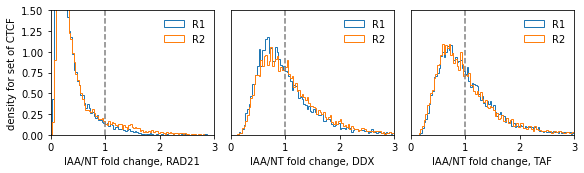

In [22]:
print(quant_dfs_dict.keys())

fig = plt.figure(figsize=(8,6), constrained_layout=True)
gsp = fig.add_gridspec(3,3)

bins = np.linspace(0,3,100)
# bins = np.linspace(-1,1,100)
for idx,s in enumerate(hist_samples):
#     if i < 1:
    i = idx//3
    j = idx%3
    loci,signal_name = s.split("-")
    ax = fig.add_subplot(gsp[i,j])
    ax.hist(dat[s+"-1"],bins=bins,cumulative=False,density=True,histtype="step",label="R1")
    ax.hist(dat[s+"-2"],bins=bins,cumulative=False,density=True,histtype="step",label="R2")
    ax.axvline(1,color="grey",linestyle="--")
    ax.set_xlim(0,3)
    ax.set_ylim(0,1.5)
    ax.legend(frameon=False)
    ax.set_xlabel(f"IAA/NT fold change, {signal_name.upper()}")
    if j ==0:
        ax.set_ylabel(f"density for set of {loci.upper()}")
    if j>0:
        ax.set_yticks([])
        ax.set_yticklabels([])

        
# plt.savefig("SuppFig5H-DDX-TAF-quant-CTCFpeaks.pdf")

In [20]:
# !scp SuppFig5G-ctcf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp SuppFig5H-DDX-TAF-quant-CTCFpeaks.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFig5G-ctcf.pdf                            100% 1239KB 382.1KB/s   00:03    
SuppFig5H-DDX-TAF-quant-CTCFpeaks.pdf         100%  380KB 314.0KB/s   00:01    
